1. Importing Libraries 

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

warnings.filterwarnings("ignore")

2. Dataset and Data Preprocessing

In [9]:
vanc_set = pd.read_csv("crime.csv")

#print(vanc_set.columns)
 
def preprocess_vancouver(df):
    # Converting to Datetime by using Time Information(Year, Month, Day, Hour, Minute)
    df['Datetime'] = pd.to_datetime(dict(
        year=df['YEAR'],
        month=df['MONTH'],
        day=df['DAY'],
        hour=df['HOUR'],
        minute=df['MINUTE']
    ), errors='coerce')

    df = df[df['Datetime'].notnull()]  # Geçerli tarihleri al
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Weekday'] = df['Datetime'].dt.weekday

    return df

van_test = preprocess_vancouver(vanc_set)




3. Daily Summary

In [10]:
def build_daily_summary(df, area_col, date_col, crime_col):
    df['day'] = df[date_col].dt.date
    grouped = df.groupby([area_col, 'day'])

    daily_features = []

    for (area, day), group in grouped:
        summary = {
            area_col: area,
            'DAY': day,
            'Crime_Count': len(group),
            'Crime_Mode': group[crime_col].mode()[0] if not group[crime_col].mode().empty else None
        }

        daily_features.append(summary)

    return pd.DataFrame(daily_features)

summary_df = build_daily_summary(
    van_test,
    area_col='NEIGHBOURHOOD',
    date_col='Datetime',
    crime_col='TYPE'
)

4. Rare Crime Filtering

In [11]:
def filter_rare_labels_percentile(df, label_col='Crime_Mode', lower_percentile=10, upper_percentile=95):
    value_counts = df[label_col].value_counts()
    lower_thresh = np.percentile(value_counts.values, lower_percentile)
    upper_thresh = np.percentile(value_counts.values, upper_percentile)
    valid_classes = value_counts[(value_counts >= lower_thresh) & (value_counts <= upper_thresh)].index
    filtered_df = df[df[label_col].isin(valid_classes)]
    return filtered_df

# Filtreleme uygulaması
summary_df = filter_rare_labels_percentile(summary_df, label_col='Crime_Mode', lower_percentile=50, upper_percentile=65)

5. Time Series Construction

In [12]:
def build_time_series(data, area_col, day_col, label_col, window_size=7):
    data = data.sort_values(by=[area_col, day_col])
    data.reset_index(drop=True, inplace=True)
    features, labels = [], []

    grouped = data.groupby(area_col)

    for _, group in grouped:
        group = group.sort_values(by=day_col)
        group = group.reset_index(drop=True)

        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            label_day = group.iloc[i+window_size]

            if pd.isnull(label_day[label_col]):
                continue

            window_features = window.drop(columns=[area_col, day_col, label_col], errors='ignore')
            features.append(window_features.to_numpy().flatten())
            labels.append(label_day[label_col])

    return np.array(features), np.array(labels)

X_test, y_test_raw = build_time_series(
    summary_df,
    area_col='NEIGHBOURHOOD',
    day_col='DAY',
    label_col='Crime_Mode',
    window_size=10 # Best Window Size, taken from Training
)    

6. Scaler and Label Encoder

In [13]:
# Loading Scaler and Label Encoder used in Training of Vancouver Dataset
scaler = joblib.load("scaler_vanc.pkl")
label_encoder = joblib.load("label_encoder_vanc.pkl")

# Missing Value Filling 
X_test = np.nan_to_num(X_test)

# Shape Checking
if X_test.shape[1] != scaler.n_features_in_:
    raise ValueError(f"X_test has {X_test.shape[1]} features but scaler expects {scaler.n_features_in_}")

# Transforming
X_test_scaled = scaler.transform(X_test)
y_test = label_encoder.transform(y_test_raw)

7. Models

For Vancouver Dataset


==========Random Forest===========
Accuracy:  0.6701158683933329
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.85      0.72      8160
           1       0.76      0.48      0.59      7979

    accuracy                           0.67     16139
   macro avg       0.70      0.67      0.66     16139
weighted avg       0.69      0.67      0.66     16139



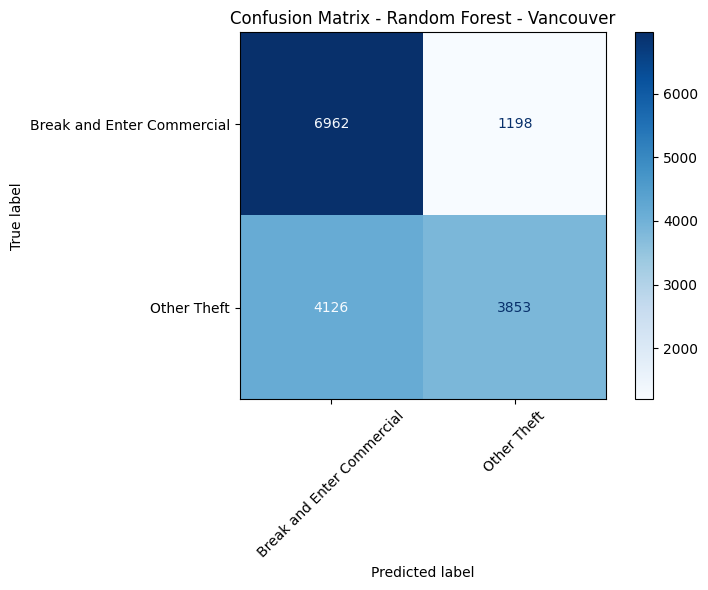


==========KNN===========
Accuracy:  0.6334964991635169
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65      8160
           1       0.64      0.59      0.61      7979

    accuracy                           0.63     16139
   macro avg       0.63      0.63      0.63     16139
weighted avg       0.63      0.63      0.63     16139



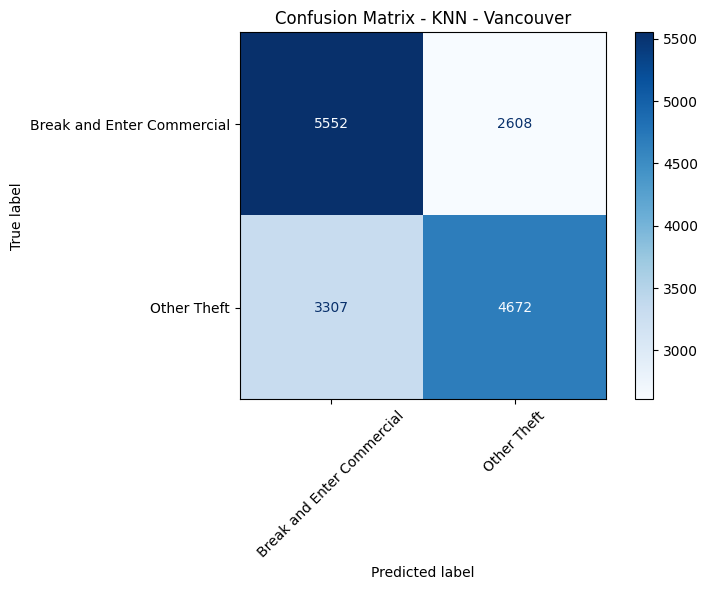


==========Naive-Bayes===========
Accuracy:  0.5447673337877192
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.89      0.66      8160
           1       0.63      0.19      0.29      7979

    accuracy                           0.54     16139
   macro avg       0.58      0.54      0.48     16139
weighted avg       0.58      0.54      0.48     16139



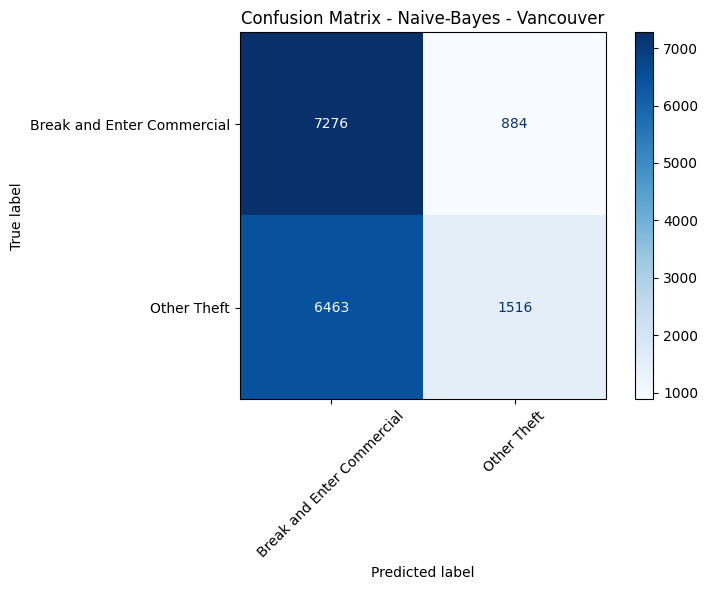


==========XGBoost===========
Accuracy:  0.5842989032777743
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.75      0.65      8160
           1       0.62      0.42      0.50      7979

    accuracy                           0.58     16139
   macro avg       0.59      0.58      0.57     16139
weighted avg       0.59      0.58      0.57     16139



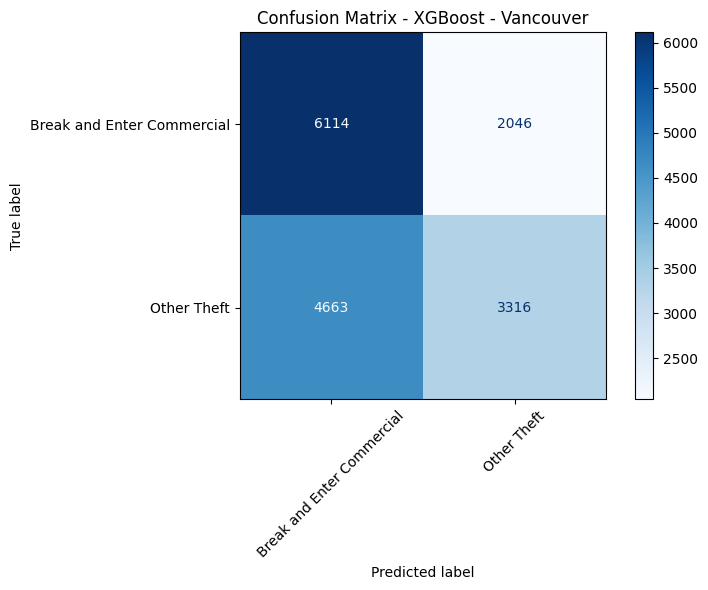


==========MLP===========
Accuracy:  0.5636656546254415
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.74      0.63      8160
           1       0.59      0.39      0.47      7979

    accuracy                           0.56     16139
   macro avg       0.57      0.56      0.55     16139
weighted avg       0.57      0.56      0.55     16139



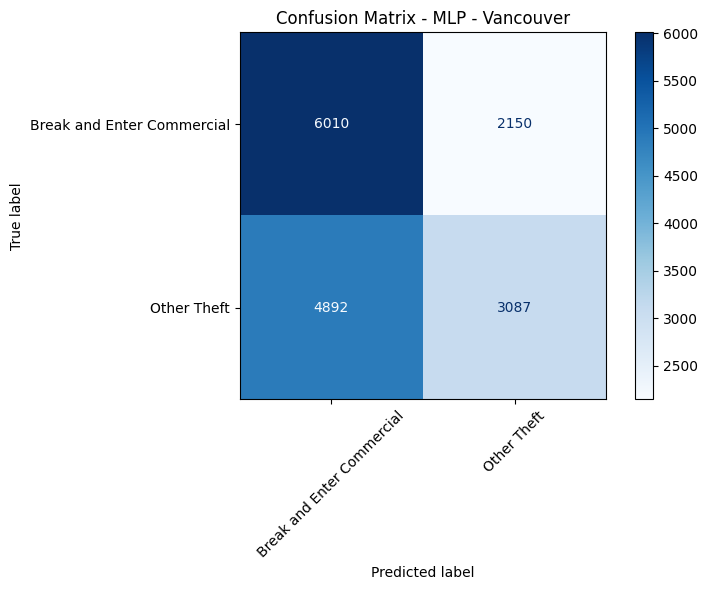

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

rf_model= joblib.load("rf_vanc_model.pkl")
knn_model= joblib.load("knn_vanc_model.pkl")
nbayes_model= joblib.load("naive_bayes_vanc_model.pkl")
xgb_model= joblib.load("xgb_vanc_model.pkl")
mlp_model= joblib.load("mlp_vanc_model.pkl")



models= {
    "Random Forest": rf_model,
    "KNN": knn_model,
    "Naive-Bayes": nbayes_model,
    "XGBoost": xgb_model,
    "MLP": mlp_model
}


print("For Vancouver Dataset\n")
for name,model in models.items():
    y_pred= model.predict(X_test_scaled)
    acc= accuracy_score(y_test,y_pred)
    print(f"\n=========={name}===========")
    print("Accuracy: ", acc)
    print("Classification Report:\n", classification_report(y_test,y_pred))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca())
    plt.title(f"Confusion Matrix - {name} - Vancouver")
    plt.tight_layout()
    plt.show()